# Fair Skin Colour Representation in Face Datasets

In one of our projects ([Face Biometrics Fairness Benchmark](https://github.com/asabuncuoglu13/fair-face)), we are developing a new benchmark to support developers conducting fairness experiments and compare their datasets or models using baseline scores. In this executable notebook, we will explore using the approaches and techniques introduced in our benchmark to analyse fairness in different datasets.

## Quantifying Skin Colour

Defining skin tone is challenging due to several factors: (1) Human skin tones vary widely across different ethnicities, ranging from very light to very dark, with numerous shades in between, making it difficult to create a universal model. (2) Skin appearance can change significantly under different lighting conditions, as variations in light intensity, color temperature, and shadows can alter the perceived color of the skin. (3) Different cameras and imaging sensors capture colors differently due to variations in hardware, settings, and post-processing algorithms, affecting the accuracy of skin tone detection. (4) Background colors and environmental conditions can influence the perceived color of skin, with reflections from nearby colored objects or surfaces casting tints on the skin. (5) Skin color can vary across different parts of the body and change over time due to factors like sun exposure, health conditions, and cosmetics, adding complexity to accurate detection. (6) Perceptions of skin tone can be subjective and influenced by cultural contexts, making standardization difficult. (7) Objects like clothing, accessories, or tattoos can occlude parts of the skin, introducing noise and making it harder to isolate and accurately measure skin tones. These challenges require sophisticated techniques and adaptive models to handle variability and ensure reliable skin tone detection in computer vision applications. 

In this challenging task, describing a skin tone value (quantifying it) naturally involves several steps and considerations. For example, we need to decide the color space transformation, skin color modeling, and segmentation approach. In this notebook, we explained following items:

1. Use Mediapipe library to get face landmarks,
2. Use these landmarks to define patches on the face
3. Convert the color space of these patches (LAB) to define ITA
4. Analyse normalised (based on ground truth) images in a dataset
5. Compare different recipes to conduct a skin tone fairness analysis

In [1]:
#!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [2]:
import glob as gb
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [4]:
# Read the golden image ids from the csv file
root_folder = '../../data/mst-e_data/'
df_gold = pd.read_csv(root_folder + 'golden_and_adversarial_mst-e_image_ids.csv')
df_gold.head()

subject                      golden_image_id          not_ideal_image_id  \
0  subject_0  PXL_20220922_134339364.PORTRAIT.jpg  PXL_20220922_134006137.jpg   
1  subject_1           PXL_20220922_174011830.jpg  PXL_20220922_174445779.jpg   
2  subject_2           PXL_20220922_173251686.jpg  PXL_20220922_173719038.jpg   
3  subject_3           PXL_20220922_193502239.jpg  PXL_20220922_193255095.jpg   
4  subject_4           PXL_20220922_161929477.jpg  PXL_20220922_162227851.jpg   

         ita  
0  40.561032  
1  34.356248  
2  19.010026  
3  42.151840  
4  21.087840

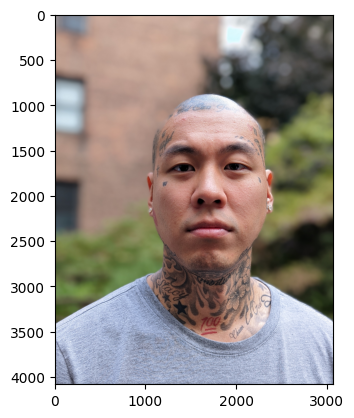

In [5]:
# Show one example image from the golden set
img_gold_id = df_gold['golden_image_id'][0]
subject_id = df_gold['subject'][0]
img_gold_path = root_folder + subject_id + '/' + img_gold_id
img_gold = cv2.imread(img_gold_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_gold[:,:,::-1])

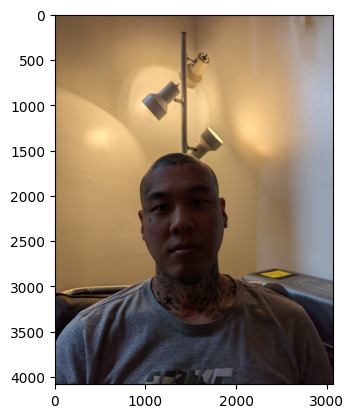

In [6]:
# Now, we will calculate the ITA for the adversarial set
img_adv_id = df_gold['not_ideal_image_id'][0]
img_adv_path = root_folder + subject_id + '/' + img_adv_id
img_adv = cv2.imread(img_adv_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_adv[:,:,::-1])

In [7]:
# Normalise this image's light density based on the golden set image
def normalise_light(img_adv, img_golden):
    lab_adv = cv2.cvtColor(img_adv, cv2.COLOR_BGR2LAB)
    lab_golden = cv2.cvtColor(img_golden, cv2.COLOR_BGR2LAB)
    l_adv = lab_adv[:, :, 0]
    l_golden = lab_golden[:, :, 0]
    if np.mean(l_adv) == 0 or np.mean(l_golden) == 0 or np.mean(l_golden) == np.mean(l_adv):
        return img_adv
    
    # It is a very simple normalisation technique/ should change it to a more sophisticated one in further iterations
    if np.mean(l_golden) > np.mean(l_adv): # golden image is brighter
        l_adv = l_adv + (np.mean(l_golden) - np.mean(l_adv)) # increase the brightness of the adversarial image
    else:
        l_adv = l_adv - (np.mean(l_adv) - np.mean(l_golden)) # decrease the brightness of the adversarial image

    # map the l values to 0 - 255 (It is how OpenCV expects the values to be)
    # see: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
    l_adv = l_adv * (255 / np.max(l_adv))
    
    # convert to int array
    lab_adv[:, :, 0] = l_adv
    img_adv = cv2.cvtColor(lab_adv, cv2.COLOR_LAB2BGR)
    return img_adv

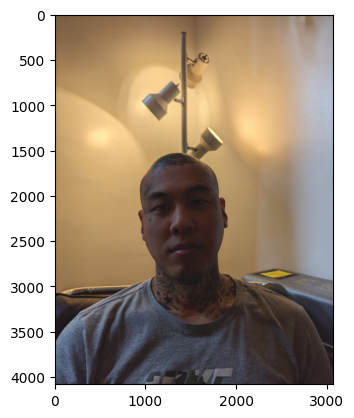

In [8]:
img_adv_normalised = normalise_light(img_adv, img_gold)
plt.imshow(img_adv_normalised[:,:,::-1])

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


In [9]:
# you can check all face mesh landmarks here: https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png

# Function to get the face landmarks
def get_face_landmarks(img_path):
    base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
    options = vision.FaceLandmarkerOptions(base_options=base_options, num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)
    img = cv2.imread(img_path)
    image = mp.Image.create_from_file(img_path)
    detection_result = detector.detect(image)
    face_landmarks_list = detection_result.face_landmarks

    landmarks = []

    if len(face_landmarks_list) == 0:
        return landmarks
    else:
        for id, lm in enumerate(face_landmarks_list[0]):
            ih, iw, ic = img.shape
            x,y,z= int(lm.x*iw),int(lm.y*ih),int(lm.z*ic)

            # Forehead
            if(id==108 or id == 151 or id == 337):
                #print("Forehead")
                landmarks.append([x,y])
            # Chin ## Don't include chin (beard)
            #if(id==199 or id == 200):
            #    print("Chin")
            #    landmarks.append([x,y])
            # Left cheek
            if(id==425):
                #print("Left cheek")
                landmarks.append([x,y])
            # Right cheek
            if(id==205):
                #print("Right cheek")
                landmarks.append([x,y])
        
        #for l in landmarks:
        #    cv2.circle(img, (l[0], l[1]), radius=20, color=(255, 0, 0), thickness=20)

    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("face_landmarks_monk.jpg", img)
    return landmarks


In [10]:
landmarks = get_face_landmarks(img_gold_path)
landmarks

I0000 00:00:1716299719.862435       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1 Pro
W0000 00:00:1716299719.865299       1 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/Users/asabuncuoglu/Documents/fair-face/.venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[[1538, 1403], [1691, 1402], [1334, 2136], [1846, 1394], [2059, 2126]]

In [11]:
# Function to extract patches from image
def extract_patches(img_path, img_golden_path, landmarks):
    img = cv2.imread(img_path)
    img_golden = cv2.imread(img_golden_path)
    lab = cv2.cvtColor(normalise_light(img, img_golden), cv2.COLOR_BGR2LAB)
    patches = []
    for points in landmarks:
        x_min = points[0] - 3
        x_max = points[0] + 3
        y_min = points[1] - 3
        y_max = points[1] + 3
        patch = lab[y_min:y_max, x_min:x_max]
        patches.append(patch)
    return patches

patches = extract_patches(img_gold_path, img_gold_path, landmarks)

In [12]:
patches[0].shape

(6, 6, 3)

In [13]:
# this ita calculation is from https://pypi.org/project/derm-ita/
import math
import numpy as np

def compute_ita_from_lab(lab):
    """
    This function computes the ITA value of the image along with ignore any pixels that are completely black
    """
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:, :, 0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)

    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)

    b = lab[:, :, 2]
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)

    ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)
    return ita

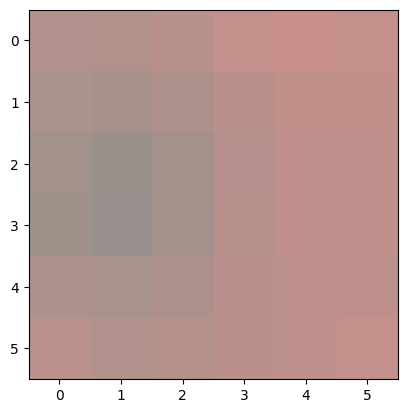

In [14]:
plt.imshow(patches[0])

In [15]:
# compute ita for all patches
def avg_ita(patches):
    itas = []
    for patch in patches:
        ita = compute_ita_from_lab(patch)
        itas.append(ita)
    return np.mean(itas)

In [16]:
# compute ita for all patches
def median_ita(patches):
    itas = []
    for patch in patches:
        ita = compute_ita_from_lab(patch)
        itas.append(ita)
    return np.median(itas)

In [17]:
ita = median_ita(patches)
ita

43.65142316522256

In [ ]:
# calculate average ita for all images in the golden set
itas = []
img_ids = list(df_gold['golden_image_id'])
subject_ids = list(df_gold['subject'])

for i in range(len(img_ids)):
    img_path = root_folder + subject_ids[i] + '/' + img_ids[i]
    landmarks = get_face_landmarks(img_path)
    patches = extract_patches(img_path, img_path, landmarks)
    #ita = avg_ita(patches)
    ita = median_ita(patches)
    itas.append(ita)

# save the ita values to the golden set csv
df_gold['ita'] = itas
df_gold.to_csv('med_golden_and_adversarial_mst-e_image_ids.csv', index=False)

In [ ]:
# Now, we will calculate the ITA for the adversarial set
itas = []
img_ids = list(df_gold['not_ideal_image_id'])
img_golden_ids = list(df_gold['golden_image_id'])
subject_ids = list(df_gold['subject'])

for i in range(len(img_ids)):
    img_path = root_folder + subject_ids[i] + '/' + img_ids[i]
    img_golden_path = root_folder + subject_ids[i] + '/' + img_golden_ids[i]
    landmarks = get_face_landmarks(img_path)
    patches = extract_patches(img_path, img_golden_path, landmarks)
    #ita = avg_ita(patches)
    ita = median_ita(patches)
    itas.append(ita)

# save the ita values to the golden set csv
df_gold['adv_ita'] = itas
df_gold.to_csv('med_golden_and_adversarial_mst-e_image_ids.csv', index=False)

In [21]:
# Read all images from mst-e_image_details.csv
df = pd.read_csv(root_folder + 'mst-e_image_details.csv')
df.head()

image_ID     pose    lighting mask subject_name  \
0  PXL_20220922_183640936.PORTRAIT.jpg  frontal  poorly_lit    0   subject_18   
1  PXL_20220922_183639710.PORTRAIT.jpg   bottom  poorly_lit    0   subject_18   
2  PXL_20220922_183638393.PORTRAIT.jpg     side  poorly_lit    0   subject_18   
3  PXL_20220922_183636542.PORTRAIT.jpg     side  poorly_lit    0   subject_18   
4  PXL_20220922_183634690.PORTRAIT.jpg     side  poorly_lit    0   subject_18   

   MST  
0    1  
1    1  
2    1  
3    1  
4    1

<Axes: xlabel='subject_name'>

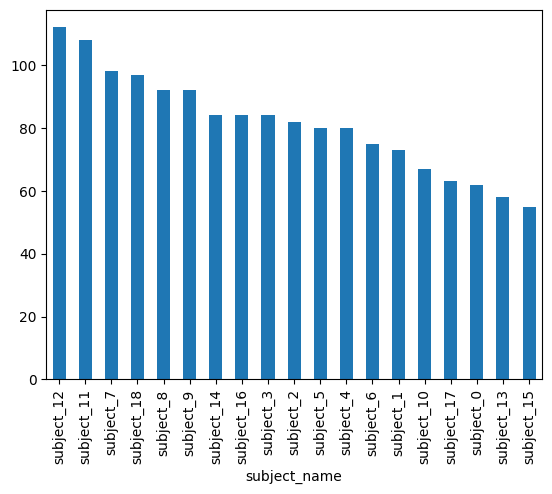

In [22]:
# plot histogram of the count of images per subject
df['subject_name'].value_counts().plot(kind='bar')

<Axes: xlabel='MST'>

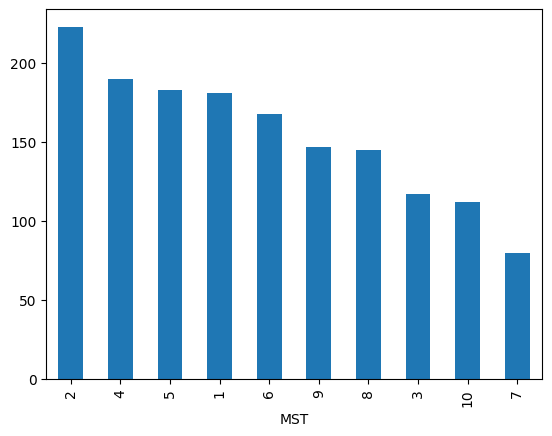

In [23]:
# plot histogram of the count of images per MST
df['MST'].value_counts().plot(kind='bar')

In [ ]:
itas = []
img_ids = list(df['image_ID'])
# subject IDs are stored as integers in the csv file, so we need to convert them to strings with prefix subject_
#subject_ids = df['subject'].apply(lambda x: 'subject_' + str(x))
subject_ids = list(df['subject_name'])

for i in range(len(img_ids)):
    img_path = root_folder + subject_ids[i] + '/' + img_ids[i]
    # if image is available and readable and .jpg
    if img_path.endswith('.jpg') and cv2.imread(img_path) is not None:
        landmarks = get_face_landmarks(img_path)
        # get the golden image path using the subject_id
        # split the subejct_id to get the subject name
        subject_name = int(subject_ids[i].split('_')[1])
        golden_img_path = root_folder + subject_ids[i] + '/' + df_gold['golden_image_id'][subject_name]

        patches = extract_patches(img_path, golden_img_path, landmarks)
        #ita = avg_ita(patches)
        ita = median_ita(patches)
        itas.append(ita)
    else:
        itas.append(None)
# save the ita values to the golden set csv
df['ita'] = itas
df.to_csv('mst-e_image_details_ita.csv', index=False)

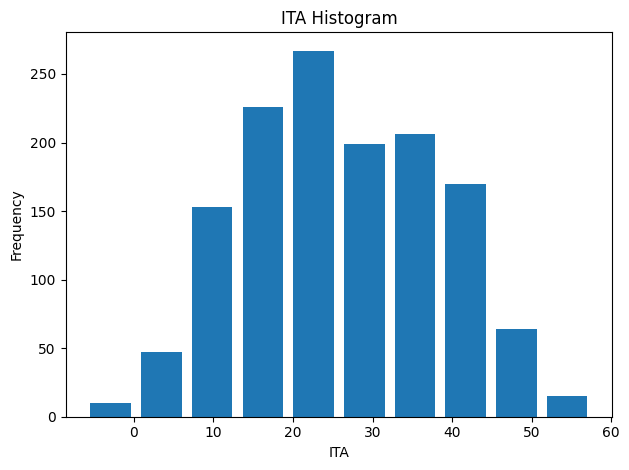

In [25]:
# Remove None values from the ITA list
itas = [i for i in itas if i is not None]

# Create histogram of the ITA values with 10 bins
plt.hist(itas, bins=10, rwidth=0.8)
# Add labels and title
plt.xlabel('ITA')
plt.ylabel('Frequency')
plt.title('ITA Histogram')
# Put some space between bars and add border
plt.tight_layout()
# Show the plot
plt.show()